In [5]:
# Standard Library Imports
import os
import sys
from importlib import reload

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
                
import open_ds

import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Logging
logger = utils.get_notebook_logger()

In [6]:
import listXarray as lxr

In [7]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:37657
-   dashboard at:        /proxy/39449/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:35017'
-         Start Nanny at: 'tcp://127.0.0.1:38833'
-         Start Nanny at: 'tcp://127.0.0.1:35155'
-         Start Nanny at: 'tcp://127.0.0.1:45347'
-         Start Nanny at: 'tcp://127.0.0.1:43705'
-         Start Nanny at: 'tcp://127.0.0.1:46267'
-         Start Nanny at: 'tcp://127.0.0.1:40331'
- Register worker <WorkerState 'tcp://127.0.0.1:46635', name: 6, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:46635
- Starting established connection to tcp://127.0.0.1:44056
- Register worker <WorkerState 'tcp://127.0.0.1:42541', name: 4, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:42541
- Starting established connection to tcp://127.0.0.1:44126
- Register worker <WorkerState 'tcp://127.0.0.1:43399', name: 3, status

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39449/status,
Dashboard: /proxy/39449/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37657,Workers: 7
Dashboard: /proxy/39449/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:46609,Total threads: 4
Dashboard: /proxy/37567/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:35017,


In [8]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# BEST Data Set

In [9]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

In [10]:
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [12]:
ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

0.3.0


In [13]:
ds = ds.rename({'latitude':'lat', 'longitude': 'lon'})

In [14]:
ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(ds.time.values))

In [15]:
ds_smean = ds.clima.space_mean()

In [16]:
ds_smean = ds_smean.compute()

In [17]:
ds_smean = ds_smean.resample(time='Y').mean()

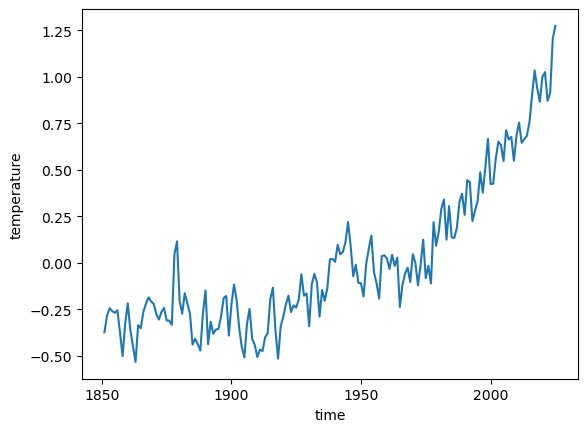

In [18]:
ds_smean.plot()

In [19]:
sn.signal_to_noise

<function signal_to_noise.signal_to_noise(window: int, da: xarray.core.dataarray.DataArray, da_for_noise: Optional[xarray.core.dataarray.DataArray] = None, rolling_noise: bool = True, method: str = 'gradient', logginglevel='ERROR', detrend: bool = True, detrend_kwargs: Dict = {}, time_slice: Tuple[int] = None, center=True, return_all=False) -> xarray.core.dataarray.DataArray>

In [23]:
ds_smean = ds_smean.where(ds_smean.time.dt.year.isin(np.arange(1900, 2025)), drop=True)

In [24]:
ds_sn = sn.signal_to_noise(20, ds_smean, detrend_kwargs={'method':'polynomial', 'order':3}, 
                          return_all=True)

20, 

In [25]:
ds_sn = ds_sn.compute()

In [26]:
ds_sn

<xarray.Dataset>
Dimensions:          (time: 125, window: 1)
Coordinates:
  * time             (time) object 1900-12-31 00:00:00 ... 2024-12-31 00:00:00
  * window           (window) int64 20
Data variables:
    signal           (window, time) float64 -0.03993 0.07327 0.1773 ... nan nan
    da_for_noise     (time) float64 0.3231 0.2267 0.06038 ... 0.08815 0.1204
    noise            (window, time) float64 0.1437 0.1192 0.1039 ... nan nan nan
    signal_to_noise  (window, time) float64 -0.2779 0.6145 1.706 ... nan nan nan

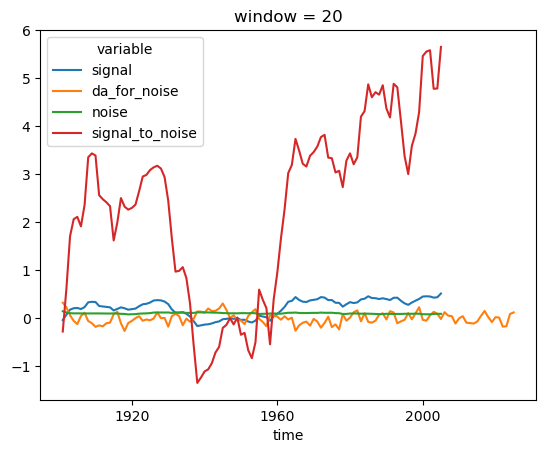

In [29]:
ds_sn.to_array().plot(hue='variable');

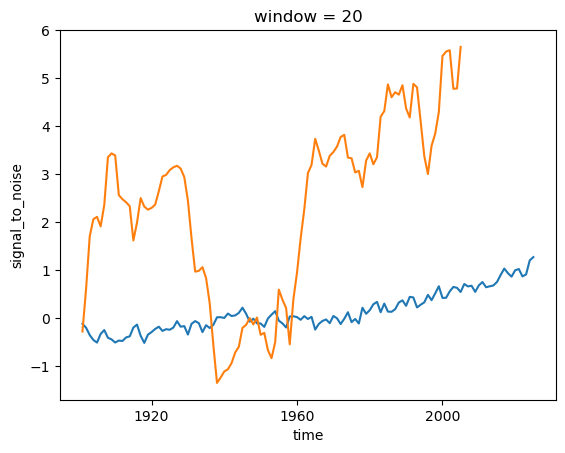

In [28]:
ds_smean.plot()
ds_sn.signal_to_noise.plot()

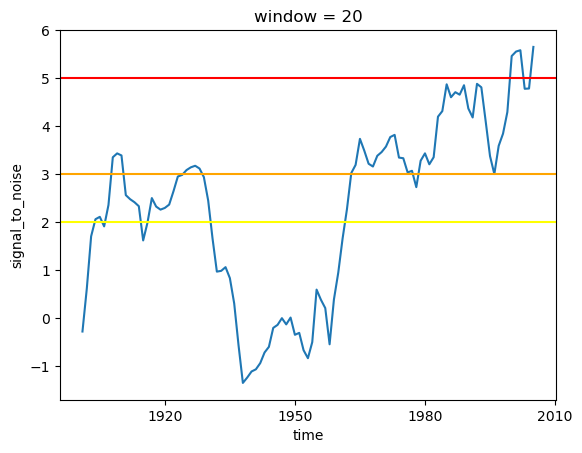

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ds_sn.signal_to_noise.plot(ax=ax)
ax.axhline(2, color='yellow')
ax.axhline(3, color='orange')
ax.axhline(5, color='red')

In [ ]:
from statsmodel.tas